In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


%load_ext autoreload
%autoreload 2
sns.set()
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters for calculation


A dictionary is supplied to the function to define the three components: distance, timedistance, and attribute distance.

The keys expected are: `distance`, `timedistance`, `attributes`

Each of these have a dictionary with the following keys: `fieldnames`, `function`, `weights` and `normalize_n`|`normalize_k`|`normalize_mean`

`fieldnames` provides the name of the fields in the table that specify the data for that component. The `distance\fieldnames` expects a dictionary with `x` and `y` information. The `timedistance` expects a dictionary with a `datetime` key, and attributes expects a list of field names.

`function` defines the function to be used to calculate the distance between two rows in the table. These can be defined as lambda functions: lambda x,y: what the function does. Two values (x and y) need to be passed to the function because there will always be two rows being compared. With `attributes` `function` expects a list of functions that correspond to each attribute.

`weights` are the weight to be applied to that particular component. `weights` for `attributes` expects a list of weights for each field.


Each component expects the distance value to be normalized by an amount. There are three options: `normalize_n`,`normalize_k`,and `normalize_mean`

`normalize_n` divides the distance by the number that is provided. If not using this provide a value of `None`. This should work for any of the components

`normalize_k` divides the distance by the maximum of the k nearest neighbors where k is the value provided. This should work with the distance component. If not using this provide a value of `None`.

`normalize_mean` divides the distance by the mean of that field. If not using this provide a value of `False`.



### Functions

Functions should expect two arrays `x` and `y` where x has a length of $1\text{x}k$ (number of variables, or 2 for latitude and longitude), and y has a length of $(n-1)\text{x}k$. This helps with the speed of processing data.

`lambda x,y: spatial.distance.cdist([x],y)` uses the scipy cdist function to calculate the distance between 1 point (`x`) and all the points in `y`

`lambda x,y: np.vectorize(lambda z: np.abs(z.days))(x-y)` Takes the difference between timepoint 1 (`x`) and all other timepoints in `y`, then retrieves the absolute days between them.

`lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1)` Is the absolute difference between value 1 (`x`) and all other values in `y`. This divided by the maximum between x and y, or 1 (this is to catch any division by zero errors). This normalizes the data between 0 and 1, so normalize_n parameter is set to 1.

In [8]:
from scipy import spatial

params = {"distance":{"fieldnames":{"x":"ShootLong","y":"ShootLat"},"function": lambda x,y: spatial.distance.cdist([x],y), 
                      "normalize_n": None, "normalize_k":12,"normalize_mean": False, "weights":1.0}, #Euclidean distance between two points, normalized by the maximum distance of the 6 nearest neighbors
          "timedistance":{"fieldnames":{"datetime":"DateTime"},"function": lambda x,y: np.vectorize(lambda z: np.abs(z.days))(x-y), 
                  "normalize_n": 60, "normalize_k": None,"normalize_mean": False, "weights":1.0}, #Absolute distance in days, normalized by 60 days.
          "attributes":{"fieldnames":["Clupea_harengus_JUV","Clupea_harengus_SA","Clupea_harengus_LA"],
                        "function": [lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1),lambda x,y: np.abs(x-y)/max(max(np.max(x),np.max(y)),1)],
                        "normalize_n":[1,1,1], "normalize_k": [None,None,None], "normalize_mean": [False,False,False], "weights":[1.0,1.0,1.0]}} #Absolute difference between two values, normalized by the average of that field



In [9]:
params

{'distance': {'fieldnames': {'x': 'ShootLong', 'y': 'ShootLat'},
  'function': <function __main__.<lambda>(x, y)>,
  'normalize_n': None,
  'normalize_k': 12,
  'normalize_mean': False,
  'weights': 1.0},
 'timedistance': {'fieldnames': {'datetime': 'DateTime'},
  'function': <function __main__.<lambda>(x, y)>,
  'normalize_n': 60,
  'normalize_k': None,
  'normalize_mean': False,
  'weights': 1.0},
 'attributes': {'fieldnames': ['Clupea_harengus_JUV',
   'Clupea_harengus_SA',
   'Clupea_harengus_LA'],
  'function': [<function __main__.<lambda>(x, y)>,
   <function __main__.<lambda>(x, y)>,
   <function __main__.<lambda>(x, y)>],
  'normalize_n': [1, 1, 1],
  'normalize_k': [None, None, None],
  'normalize_mean': [False, False, False],
  'weights': [1.0, 1.0, 1.0]}}

### Required Libraries

1. numpy
2. pandas
3. scipy
4. sklearn
5. pyproj

#### Optional

1. geopandas
2. shapely
3. fiona
4. contextily 

The optional libraries are used to create maps for plotting and understanding the clusters.



## Loading the tool

1. Create a new object from STHC
2. Load the dataset from the csv file. This may take a while if you need to convert the points from latitude and longitude. This could be done in advance.
3. Calculate the distance matrixs
4. Calcuate the linkages
5. Determine the number of clusters


If you are using latitude and longitude, then these will need to be transformed to a projected coordinate system for the study area. This is for the distance calculations. 

### Map projections for the north sea area?

WGS 84 / UTM zone 31N
EPSG:32631

ED_1950_TM_0_N 
EPSG: 23090

In [12]:
# %load /Users/markrademaker/Projects/Spatio_temporal_clustering/Script/sthc.py
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from scipy import spatial
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_samples, silhouette_score
from shapely.geometry.point import Point
from datetime import timedelta
from dateutil import parser
import datetime
import pandas as pd
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.cluster import hierarchy
from scipy import spatial
from scipy.ndimage import gaussian_filter

class MissingDataset(Exception):
    """Exception raised for errors in the input.

    Attributes:
        expression -- input expression in which the error occurred
        message -- explanation of the error
    """

    def __init__(self, expression, message):
        self.expression = expression
        self.message = message



class STHC(object):
    def __init__(self):
        self.functions = []
        self.data = None
        self.df = None
        self.X = None
        self.distance_params = {}
        self.timedistance_params = {}
        self.attribute_params = {}
        self.tree = None
        self.attribute_norm_values = {}
        self.sqdm = None

    def calculate_clusters(self,method='average'):
        self.row_clusters = linkage(self.dm,method='average')

    def print_dendrogram(self,figsize=(9,6),dpi=300):
        colors_grey = [n for n,hex in colors.cnames.iteritems() if 'grey' in n]
        #print colors_grey
        hierarchy.set_link_color_palette(None)#hierarchy.set_link_color_palette(colors_grey)
        color_list=plt.get_cmap('Greys')
        fig = plt.figure(figsize=figsize,dpi=dpi)

        #frame1.axes.yaxis.set_ticklabels([])
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Index')
        plt.ylabel('Distance')
        row_dendr = dendrogram(self.row_clusters)
        frame1 = plt.gca()
        #frame1.set_position([0, 0, 1, 1])
        frame1.axes.xaxis.set_ticklabels([])
        plt.show()

    def calculate_distance_matrix(self):
        
        if isinstance(self.df, type(None)):
            raise MissingDataset("calcualte_distance_matrix","Need to load the dataset first...")
        else:
            #self.dm_old = pdist(self.X, self.calculate_distance)
            try:
                del self.dm
            except:
                pass
            self.dm = self.pdist_custom(self.X,self.distfunc,self.timefunc,self.attribute_params['function'],self.weights)


    def calculate_distance(self,x,y):
        weights = []
        finalsum = []
        # Calculate distance between two points
        
        dist = self.distfunc(x[0:2],y[0:2])
        dist_norm = dist / x[2]
        #print(dist_norm)
        finalsum.append(dist_norm)
        weights.append(self.distance_params['weights'])
        #calcualte the difference in time

        dist_time = self.timefunc(x[3],y[3])
        dist_time_norm = dist_time/x[4]
        #print(dist_time_norm)

        finalsum.append(dist_time_norm)
        weights.append(self.timedistance_params['weights'])
        # Calculate values for attributes
        #dist_att = []
        dist_att_norm = []
        for i in range(0,len(self.attribute_params['fieldnames'])+2,2):
            x_i = i + 5
            x_n_i = i +5+ 1
            dist_att_norm.append((x[x_i],y[x_i],x[x_n_i]))
        for i in range(0,len(self.attribute_params['fieldnames'])):
            dist_a_i = self.attribute_params['function'][i](dist_att_norm[i][0],dist_att_norm[i][1])
            #print(dist_a_i)
            finalsum.append(dist_a_i / dist_att_norm[i][2])
            weights.append(self.attribute_params['weights'][i])

        #print(finalsum)
        
        res = np.sum([v*w for v,w in zip(finalsum,weights)])/np.sum(weights)

        if res >=0.0:
            return res
        else:
            return 0.0
        #return 1.0

    def pdist_custom(self,X,distfunc,timefunc,attributefuncs,weights):
        """distance matrix that doesn't rely on numpy's pdist. speed check"""
        n = X.shape[0]

        #empty array
        dm = np.zeros(int(n*(n-1)/2.0))
        for i in range(n-1):
            x = X[i]
            y = X[i+1:]
            ress = []
            #for y in Y:
            finalsum = 0.0

            if distfunc:
                dist = distfunc(x[0:2],y[:,0:2])[0]
                #print(dist)
                dist_norm = dist / x[2]
                #print(dist_norm)
                finalsum = dist_norm * weights[0]
            
            if timefunc:
                dist_time = timefunc(x[3],y[:,3])
                #print(dist_time)
                dist_time_norm = dist_time/x[4]
                #print(dist_time_norm)
                finalsum += dist_time_norm * weights[1]

            base = 5
            for j in range(0,len(attributefuncs)):
                x_i = j + base
                x_n_i = j + base+1
                f = attributefuncs[j]
                if f != None:
                    t = f(x[x_i],y[:,x_i]) / x[x_n_i] * weights[j+2] 
                    finalsum = finalsum+ t
                base += 1
            res = finalsum/np.sum(weights)
            #ress.append(res)
            idx_s = int((2 * n - i - 1) * i / 2.0)
            idx_e = int((2 * n - i - 2) * (i + 1) / 2.0)
            dm[idx_s:idx_e] = res
        
        return dm

    def load_dataset_csv(self,path,params,toepsg=None,dayfirst = True,sample=None):
        """Load a csv file to be used in the space-time hierarchical clustering
        path: string path to the csv file to be used.
        params: dictionary specifying the functions to calculate the distance between different components
        toepsg: epsg code to transform latitude and longitude coordinates to planar coordinates.
        dayfirst: for date conversion. if days are first in the date string.
        sample: if None, use the full dataset, if <1 use a percentage of the dataset, if > 1 use as the sample size
        Planar coordinates are used because the points are placed in a kdtree for faster calculations.
        """
        print("Reading the file...")
        self.df = pd.read_csv(path)
        if sample:
            if sample<1:
                self.df = self.df.sample(frac=sample,replace=False)
            elif sample >1:
                self.df = self.df.sample(n=sample,replace=False)
        self.distance_params = params['distance'].copy()
        self.timedistance_params = params['timedistance'].copy()
        self.attribute_params = params['attributes'].copy()
        self.distance_params['field_index'] = [0,1] #need to now the structure of the array when calculating between points
        self.timedistance_params['field_index'] = [2]
        #self.attribute_params['field_index'] = [i+3 for i,x in enumerate(self.attribute_params['fieldnames'])]
        self.distfunc = self.distance_params['function']
        self.timefunc = self.timedistance_params['function']
        fieldlist = [] #for extracting the fields into the array used in the distance calculations

        xfn = self.distance_params['fieldnames']['x']
        yfn = self.distance_params['fieldnames']['y']
        dtfn = self.timedistance_params['fieldnames']['datetime']
        attributefields = self.attribute_params['fieldnames']

        xs = [] #if converting over
        ys = []
        dts = []
        print(xfn)
        print(yfn)
        print('Processing table for datetime and coordinates...')

        #for idx,row in self.df.iterrows():
        #    if toepsg:
        #        try:
        #            xt, yt = self.transform_pnt(toepsg,row[xfn],row[yfn])
        #        except:
        #            xt = np.nan
        #            yt = np.nan
        #        xs.append(xt)
        #        ys.append(yt)
        #    try:
        #        dtt = self.convertDate(row[dtfn])
        #    except:
        #        dtt = None

        #    dts.append(dtt)
        #    if idx%1000==0:
        #        print(idx)
        
        if toepsg:
            transformer = Transformer.from_crs(4326, toepsg)
            res = self.df[[xfn,yfn]].apply(lambda x: transformer.transform(x[0],x[1]),axis=1)
            self.df[xfn] = res.apply(lambda x: x[0])
            self.df[yfn] = res.apply(lambda x: x[1])
        
        if self.distance_params['normalize_n']:
            self.df['dist_norm'] = np.ones(len(self.df)) * self.distance_params['normalize_n']
        elif self.distance_params['normalize_k']:
            self.tree = spatial.KDTree(self.df[[xfn,yfn]].values)
            nn = self.df[[xfn,yfn]].apply(lambda x: self.tree.query(x,k=self.distance_params['normalize_k']),axis=1)
            self.df['dist_norm'] = nn.apply(lambda x: np.max(x[0]))
            self.df['dist_norm'] = self.df['dist_norm'] + 1.0
        elif  self.distance_params['normalize_mean']:
            raise NotImplementedError("normalizing distannce by mean of distance not implemented, use normalize_n or nearest neighbor")

        self.df[dtfn] = self.df[dtfn].apply(lambda x: parser.parse(x,dayfirst=dayfirst))

        if self.timedistance_params['normalize_n']:
            self.df['timenorm'] =  np.ones(len(self.df))*self.timedistance_params['normalize_n']
        elif self.timedistance_params['normalize_k']:
            raise NotImplementedError("normalizing by k nearest neighbors for time not implemented, use normalize_n")
        elif  self.distance_params['normalize_mean'] == True:
            raise NotImplementedError("normalizing by mean of time not implemented, use normalize_n")
        

        fieldlist.append(xfn)
        fieldlist.append(yfn)
        fieldlist.append('dist_norm')
        fieldlist.append(dtfn)
        fieldlist.append('timenorm')

        print('Preparing attribute normalization....')
        normalize_fields = []
        for i,afn in enumerate(self.attribute_params['fieldnames']):
            if self.attribute_params['normalize_n'][i]:
                self.df['attnorm{0}'.format(i)]= np.ones(len(self.df)) * self.attribute_params['normalize_n'][i]
                normalize_fields.append('attnorm{0}'.format(i))
            elif self.attribute_params['normalize_mean'][i] == True:
                self.df['attnorm{0}'.format(i)]= np.ones(len(self.df)) *  self.df[afn].mean()
                normalize_fields.append('attnorm{0}'.format(i))
            elif self.attribute_params['normalize_k']:
                raise NotImplementedError("normalizing by k nearest neighbors for attributes not implemented, use normalize_n")

        for af,afn in zip(attributefields,normalize_fields):
            fieldlist.append(af)
            fieldlist.append(afn)

        self.X = self.df[fieldlist].values

        self.weights = []
        self.weights.append(params['distance']['weights'])
        self.weights.append(params['timedistance']['weights'])
        self.weights += params['attributes']['weights']


    def elbow_plot(self,n_clusters=None):
        if n_clusters == None:
            n_clusters = list(range(2,int(len(self.X)/2),10))
        outScores = []
        for n_c in n_clusters:
            try:
                #print "number of clusters %s"%n_c
                cluster_labels = fcluster(self.row_clusters, n_c, criterion='maxclust')
                #print cluster_labels
                ssq = self.silhouette_avg_custom(self.X.shape[0],self.dm,cluster_labels,self.square_to_condensed)
                #silhouette_avg = silhouette_score(self.sqdm + self.sqdm.T,cluster_labels,metric='euclidean')
                outScores.append(ssq)
            except:
                pass
        a = np.array(list(zip(n_clusters,outScores)))
        smoothed = gaussian_filter(a[:,1], 3.)
        bottom = np.gradient(smoothed)[::-1].argmin()
        #print(bottom)
        #print(len(smoothed) - np.gradient(smoothed)[::-1].argmin())
        fig = plt.figure(figsize=(5,5),dpi=300)
        ax = fig.add_subplot(111)
        ax.plot(a[:,0],a[:,1],'.')
        plt.plot(a[:,0], smoothed, '-')
        plt.plot(a[bottom][0], smoothed[bottom], 'o')
        ax.set_xticks(n_clusters)
        print("Try {0} clusters...".format(a[bottom][0]))
        #print("Try {0} clusters...".format(a[len(smoothed)-np.gradient(smoothed)[::-1].argmin()][0]))
        plt.show() 
        return list(zip(n_clusters,outScores))

    def elbow_ssq(self,n,dm,cluster_labels,vf):
        f = np.vectorize(vf)
        scores = 0.0
        for c in np.unique(cluster_labels):
            indexes = (cluster_labels==c).nonzero()[0]
            all_distances = []
            for i in range(len(indexes)):
                x = indexes[i]
                y = indexes[i+1:]
                dist_within = np.array([])
                if i!=0:
                    y = np.append(y,indexes[0:i])
                if len(y)>0:
                    dist_within = dm[f(x,y,n).astype(int)]
                all_distances += list(dist_within)
            scores += np.var(all_distances)
        return scores
    
    def elbow_alt(self,max_n_clusters=None):
        #from here:https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
        if max_n_clusters == None:
            max_n_clusters = int(len(self.X)/2)
        last = self.row_clusters[-max_n_clusters:, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        plt.plot(idxs, last_rev)

        slope = np.diff(last, 1)
        slope = np.gradient(last)
        slope_rev = slope[::-1]
        #print ("Optimal Clusters Slope: {0}".format(slope_rev.argmax()+2))
        acceleration = np.diff(last, 2)  # 2nd derivative of the distances
        acceleration_rev = acceleration[::-1]
        plt.plot(idxs, np.gradient(last)[::-1])
        k = len(last)-np.gradient(last)[::-1].argmin()+2
        plt.plot(last[k],k,".")
        plt.show()
        #k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
        print("Try {0} clusters...".format(len(last)-np.gradient(last)[::-1].argmin()+2))
        return acceleration
    def square_to_condensed(self,i, j, n):
        assert i != j, "no diagonal elements in condensed matrix"
        if i < j:
            i, j = j, i
        return int(n*j - j*(j+1)//2 + i - 1 - j)

    def silhouette_avg_custom(self,n,dm,cluster_labels,vf):
        f = np.vectorize(vf)
        scores = []
        for c in np.unique(cluster_labels):
            indexes = (cluster_labels==c).nonzero()[0]
            for i in range(len(indexes)):
                x = indexes[i]
                y = indexes[i+1:]
                dist_within = np.array([])
                if i!=0:
                    y = np.append(y,indexes[0:i])
                if len(y)>0:
                    dist_within = dm[f(x,y,n).astype(int)]
                    dist_outside = np.array([])
                    for c_j in np.unique(cluster_labels[cluster_labels!=c]):
                        indexes_not = (cluster_labels==c_j).nonzero()[0]
                        dist_outside = np.append(dist_outside,np.mean(dm[f(x,indexes_not,n).astype(int)]))
                    scores.append((np.min(dist_outside)-np.mean(dist_within)) / max(np.mean(dist_within),np.min(dist_outside)))
                else:
                    scores.append(0)

        return np.mean(scores)
    
    def silhoutte_scores_n_clusters(self,n_clusters=None,printV=False):
        outScores = []
        if n_clusters == None:
            n_clusters = list(range(2,int(len(self.X)/2),10))
        for n_c in n_clusters:
            try:
                #print "number of clusters %s"%n_c
                cluster_labels = fcluster(self.row_clusters, n_c, criterion='maxclust')
                #print cluster_labels
                silhouette_avg = self.silhouette_avg_custom(self.X.shape[0],self.dm,cluster_labels,self.square_to_condensed)
                #silhouette_avg = silhouette_score(self.sqdm + self.sqdm.T,cluster_labels,metric='euclidean')
                outScores.append(silhouette_avg)
                if printV:
                    print ("For n_clusters =%s"%n_c)
                    print ("The average silhouette_score is : %s"%silhouette_avg)
                
            except:
                pass
        meanscore = np.mean(outScores)
        #print(meanscore)
        smoothed = gaussian_filter(outScores, 2.)
        bottom = len(smoothed)-np.gradient(smoothed)[::-1].argmin()
        #print(np.gradient(smoothed)[::-1].argmin())
        fig = plt.figure(figsize=(5,5),dpi=300)
        ax = fig.add_subplot(111)
        ax.plot(n_clusters,outScores,'.')
        plt.plot(n_clusters, smoothed, '-')
        plt.plot(n_clusters[bottom], smoothed[bottom], 'o')
        ax.set_xticks(n_clusters)
        print("Try {0} clusters...".format(np.array(n_clusters)[np.array(outScores)>meanscore][0]))
        print("Try {0} clusters...".format(n_clusters[bottom]))
        plt.show() 

        return list(zip(n_clusters,outScores))
        
    def silohetteScore(self,n_clusters,printV=False):
        outScores = []
        if isinstance(self.sqdm, type(None)):
            self.sqdm = squareform(self.dm)
        for n_c in n_clusters:
            try:
                #print "number of clusters %s"%n_c
                cluster_labels = fcluster(self.row_clusters, n_c, criterion='maxclust')
                #print cluster_labels
                silhouette_avg = silhouette_score(self.sqdm,cluster_labels,metric='precomputed')
                #silhouette_avg = silhouette_score(self.sqdm + self.sqdm.T,cluster_labels,metric='euclidean')
                outScores.append(silhouette_avg)
                if printV:
                    print ("For n_clusters =%s"%n_c)
                    print ("The average silhouette_score is : %s"%silhouette_avg)
            except:
                pass
        return outScores

    def plotClusters3D(self):
        plt.style.use('seaborn-whitegrid')
        mpl.rc('font',family='Times New Roman')
        mpl.rcParams.update({'font.size': 7})
        fig1 = plt.figure(figsize=(6,6),dpi=300)
        ax1 = fig1.add_subplot(111, projection='3d')
        ax1.set_aspect('equal')
        ax1.view_init(20, 60)
        #gdf_eqwt.plot(ax=ax,column='c2_lbl',cmap='Dark2', categorical=True,markersize=6,marker="^")
        classes = {1:{'xs':[],'ys':[],'zs':[],'c':'k','m':'o'},2:{'xs':[],'ys':[],'zs':[],'c':'gray','m':'^'}}

        ax1.xaxis.set_major_formatter(ticker.FuncFormatter(meters_formatter))
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(meters_formatter))

        ax1.xaxis.set_major_locator(ticker.MultipleLocator(200))
        ax1.yaxis.set_major_locator(ticker.MultipleLocator(200))

        ax1.set_zticks([0, 14400, 28800, 43200,57600,72000, 86400])
        for idx,row in gdf_wttime.iterrows():
            classes[row['c2_lbl']]['xs'].append(row['geometry'].x)
            classes[row['c2_lbl']]['ys'].append(row['geometry'].y)
            classes[row['c2_lbl']]['zs'].append(row['Time'])

        for k,v in classes.iteritems():
            ax1.scatter(v['xs'],v['ys'],v['zs'], c=v['c'], marker=v['m'])
            #ax1.plot(v['xs'],v['ys'],v['zs'],color=colorClusters[k],alpha=.8,marker='o',linestyle='')
            #ax1.plot(v['xs'],v['ys'],v['zs'],alpha=.8,marker='o',linestyle='')
            #plt.plot()
            #plt.plot(ks,minSc)
            #plt.plot(ks,tenc)
        ax1.set_zticklabels(["0:00","4:00","8:00","12:00","16:00","20:00","23:59"])
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Time of Day')
    


In [13]:
st = STHC()

In [14]:
#st.load_dataset_csv('Clupea_harengus_attributes.csv',params,32631,sample=500) #full 20,000+ rows of data.
st.load_dataset_csv('/Users/markrademaker/Projects/Spatio_temporal_clustering/Data/Clupea_harengus_attributes.csv',params,4326,sample=500)
#st.load_dataset_csv('medium.csv',params,32631) #1000 rows of data is easier to process and test the parameters.
len(st.df)

Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....


500

You can review the data table to check it loaded properly. This is a pandas dataframe.

In [15]:
st.df.head()

,Unnamed: 0,Survey,Year,ShootLat,ShootLong,DateTime,Clupea_harengus_JUV,Clupea_harengus_SA,Clupea_harengus_LA,dist_norm,timenorm,attnorm0,attnorm1,attnorm2
14480,14480,NS-IBTS,2006,54.9030,-0.2047,2006-02-02 16:26:00,0.0,0.0,10.0,1.700864,60.0,1.0,1.0,1.0
6601,6601,NS-IBTS,1993,55.3000,3.2000,1993-02-12 07:14:00,0.0,99.0,1062.0,1.674335,60.0,1.0,1.0,1.0
18432,18432,NS-IBTS,2013,54.8847,2.3388,2013-02-13 07:07:00,0.0,8.0,4.0,1.808740,60.0,1.0,1.0,1.0
2249,2249,NS-IBTS,1984,53.2833,4.2833,1984-02-02 09:41:00,304.0,1058.0,222.0,1.684116,60.0,1.0,1.0,1.0
4272,4272,NS-IBTS,1988,57.8833,-1.5333,1988-02-05 13:00:00,0.0,32.0,8034.0,1.908266,60.0,1.0,1.0,1.0


In [16]:
st.df.tail()

,Unnamed: 0,Survey,Year,ShootLat,ShootLong,DateTime,Clupea_harengus_JUV,Clupea_harengus_SA,Clupea_harengus_LA,dist_norm,timenorm,attnorm0,attnorm1,attnorm2
18063,18063,NS-IBTS,2012,57.4872,9.0930,2012-08-14 14:15:00,0.0,0.0,4.8,1.923807,60.0,1.0,1.0,1.0
8848,8848,NS-IBTS,1997,55.1167,7.2333,1997-01-19 10:53:00,76.0,24.0,0.0,1.589080,60.0,1.0,1.0,1.0
15767,15767,NS-IBTS,2008,57.4610,10.8607,2008-09-01 13:18:00,1268.0,1217.0,50.0,1.629279,60.0,1.0,1.0,1.0
11216,11216,NS-IBTS,2001,54.2927,6.5887,2001-08-10 08:48:00,2002.0,556.0,6.0,1.744407,60.0,1.0,1.0,1.0
15517,15517,NS-IBTS,2008,54.2560,6.3596,2008-02-28 09:52:00,24.0,66.0,12.0,1.702578,60.0,1.0,1.0,1.0


In [17]:
st.df.dtypes

Unnamed: 0                      int64
Survey                         object
Year                            int64
ShootLat                      float64
ShootLong                     float64
DateTime               datetime64[ns]
Clupea_harengus_JUV           float64
Clupea_harengus_SA            float64
Clupea_harengus_LA            float64
dist_norm                     float64
timenorm                      float64
attnorm0                      float64
attnorm1                      float64
attnorm2                      float64
dtype: object

### Optional create a geodataframe to plot the points

This geodataframe is useful for plotting the clusters after they are identified. Make sure to set the correct epsg code if that is changed from above.

/Users/markrademaker/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


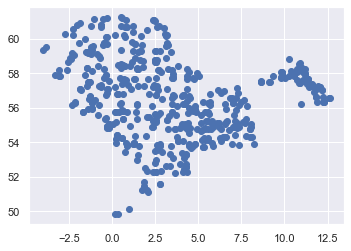

In [18]:
#gdf = gpd.GeoDataFrame(st.df,geometry=st.df[['ShootLong','ShootLat']].apply(lambda x: Point(x),axis=1),crs={'init': 'epsg:32631'})
gdf = gpd.GeoDataFrame(st.df,geometry=st.df[['ShootLong','ShootLat']].apply(lambda x: Point(x),axis=1),crs={'init': 'epsg:4326'})

gdf.plot();

## Create the distance matrix

In [19]:
from scipy import spatial
#%timeit -n 1 st.calculate_distance_matrix()
#6.08 s ± 44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) for 1000 rows
#%timeit -n 1 st.calculate_distance_matrix()
#49min 3s ± 40.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each) for 20,000+ rows
st.calculate_distance_matrix()

In [373]:
#given how long it potentially takes to create the distance matrix it may be worth saving it for use later
#np.save("Clupea_harengus_attributes_dm",st.dm)


In [374]:
#loading the distance matrix if it is saved
#dm = np.load("Clupea_harengus_attributes_dm.npy")

Create the linkages used to identify the clusters.

## Cluster Identification


In [20]:
st.calculate_clusters()

### Approaches
Identify how many clusters to create. For the silhoutte score, provide a list of numbers (number of clusters) and identify the highest positive silhoutte score. The dendrogram can also be used to identify the number of clusters.

### Elbow Plot

Identify the point where the curve begins to flatten. The two approaches may give different number of clusters.

Try 222.0 clusters...


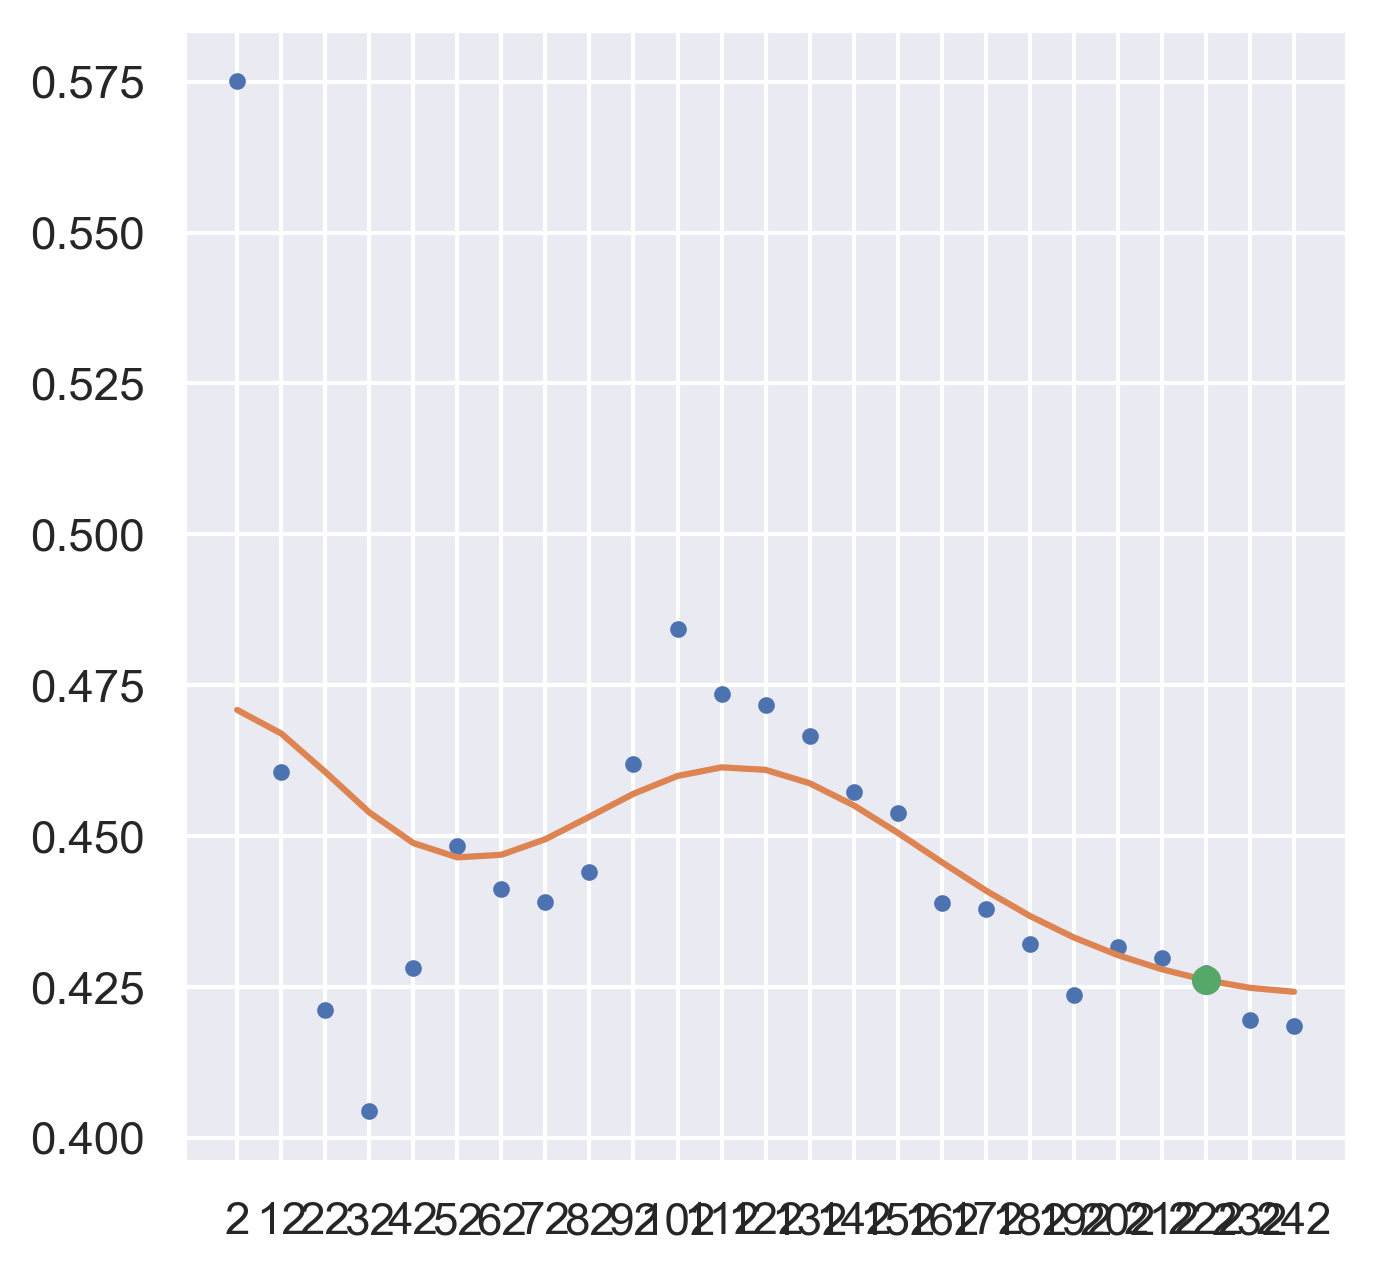

In [21]:
a = st.elbow_plot()


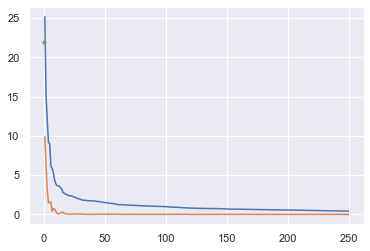

Try 22 clusters...


In [22]:
a = st.elbow_alt()

### Silhoutte Score

The silhoutte score closest to 1 indicates a better potential fit to the number of clusters. This may be a small number of clusters so a plot might be used to evaluate the score pattern and find some better fitting number of clusters.

Try 2 clusters...
Try 32 clusters...


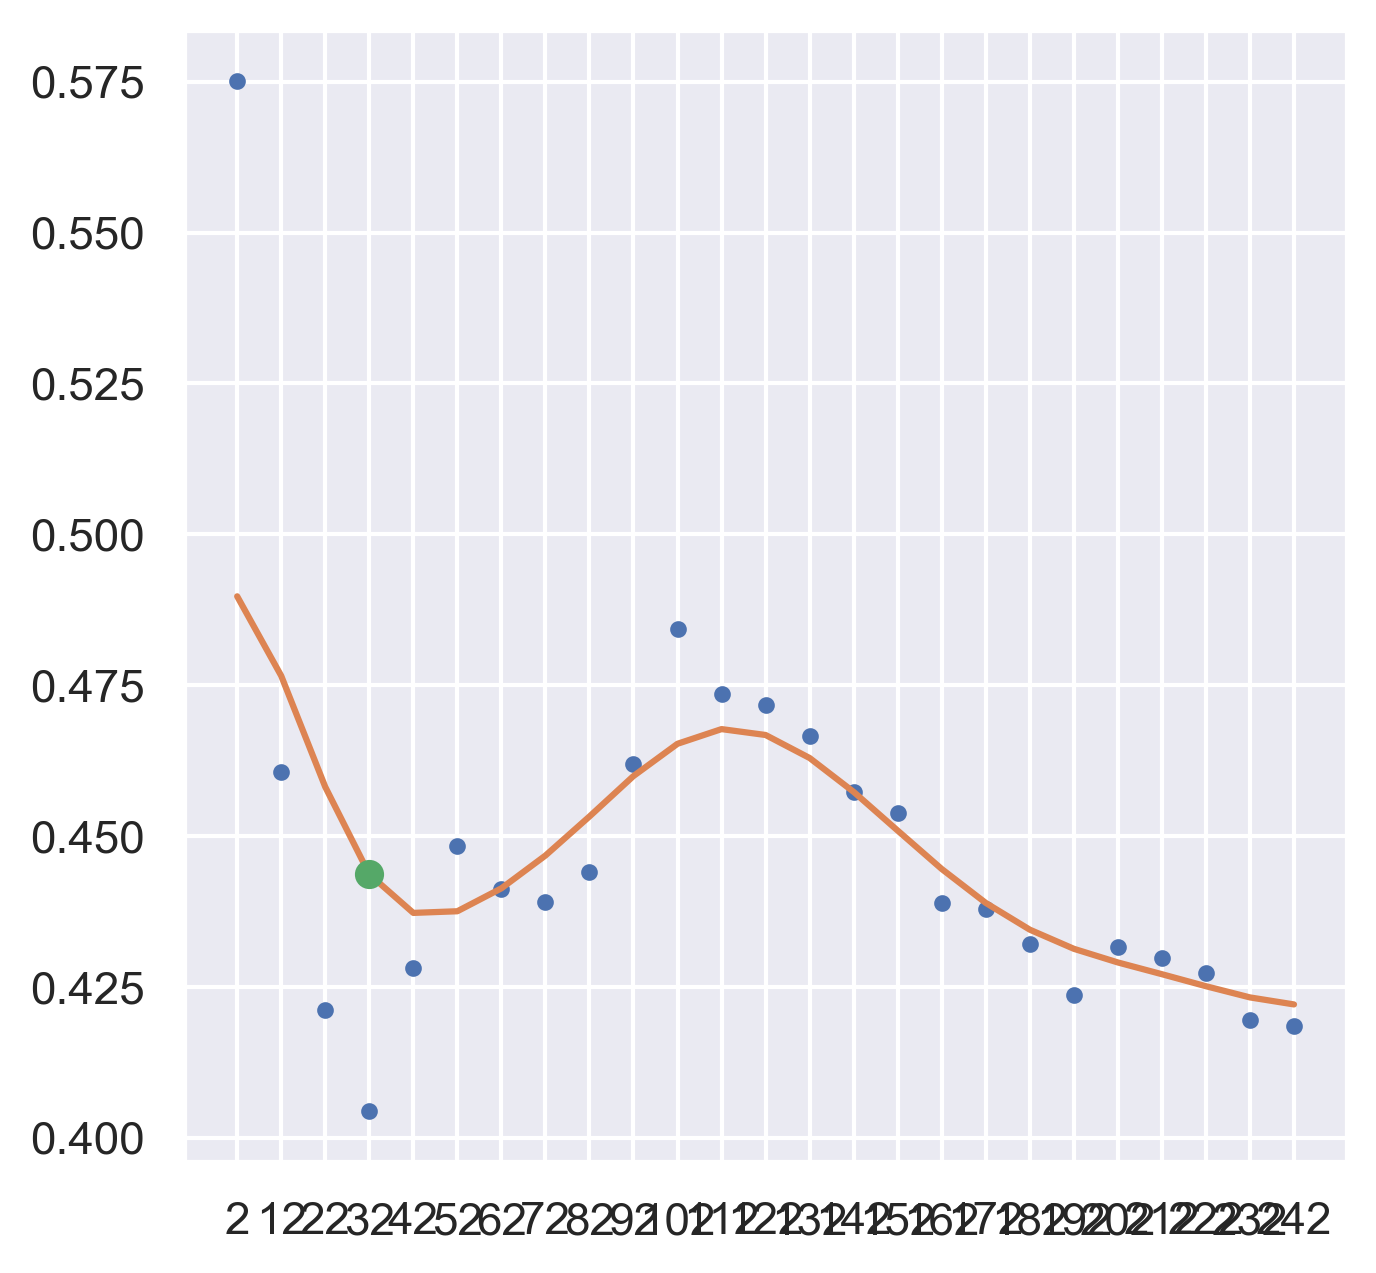

In [23]:
a = st.silhoutte_scores_n_clusters()

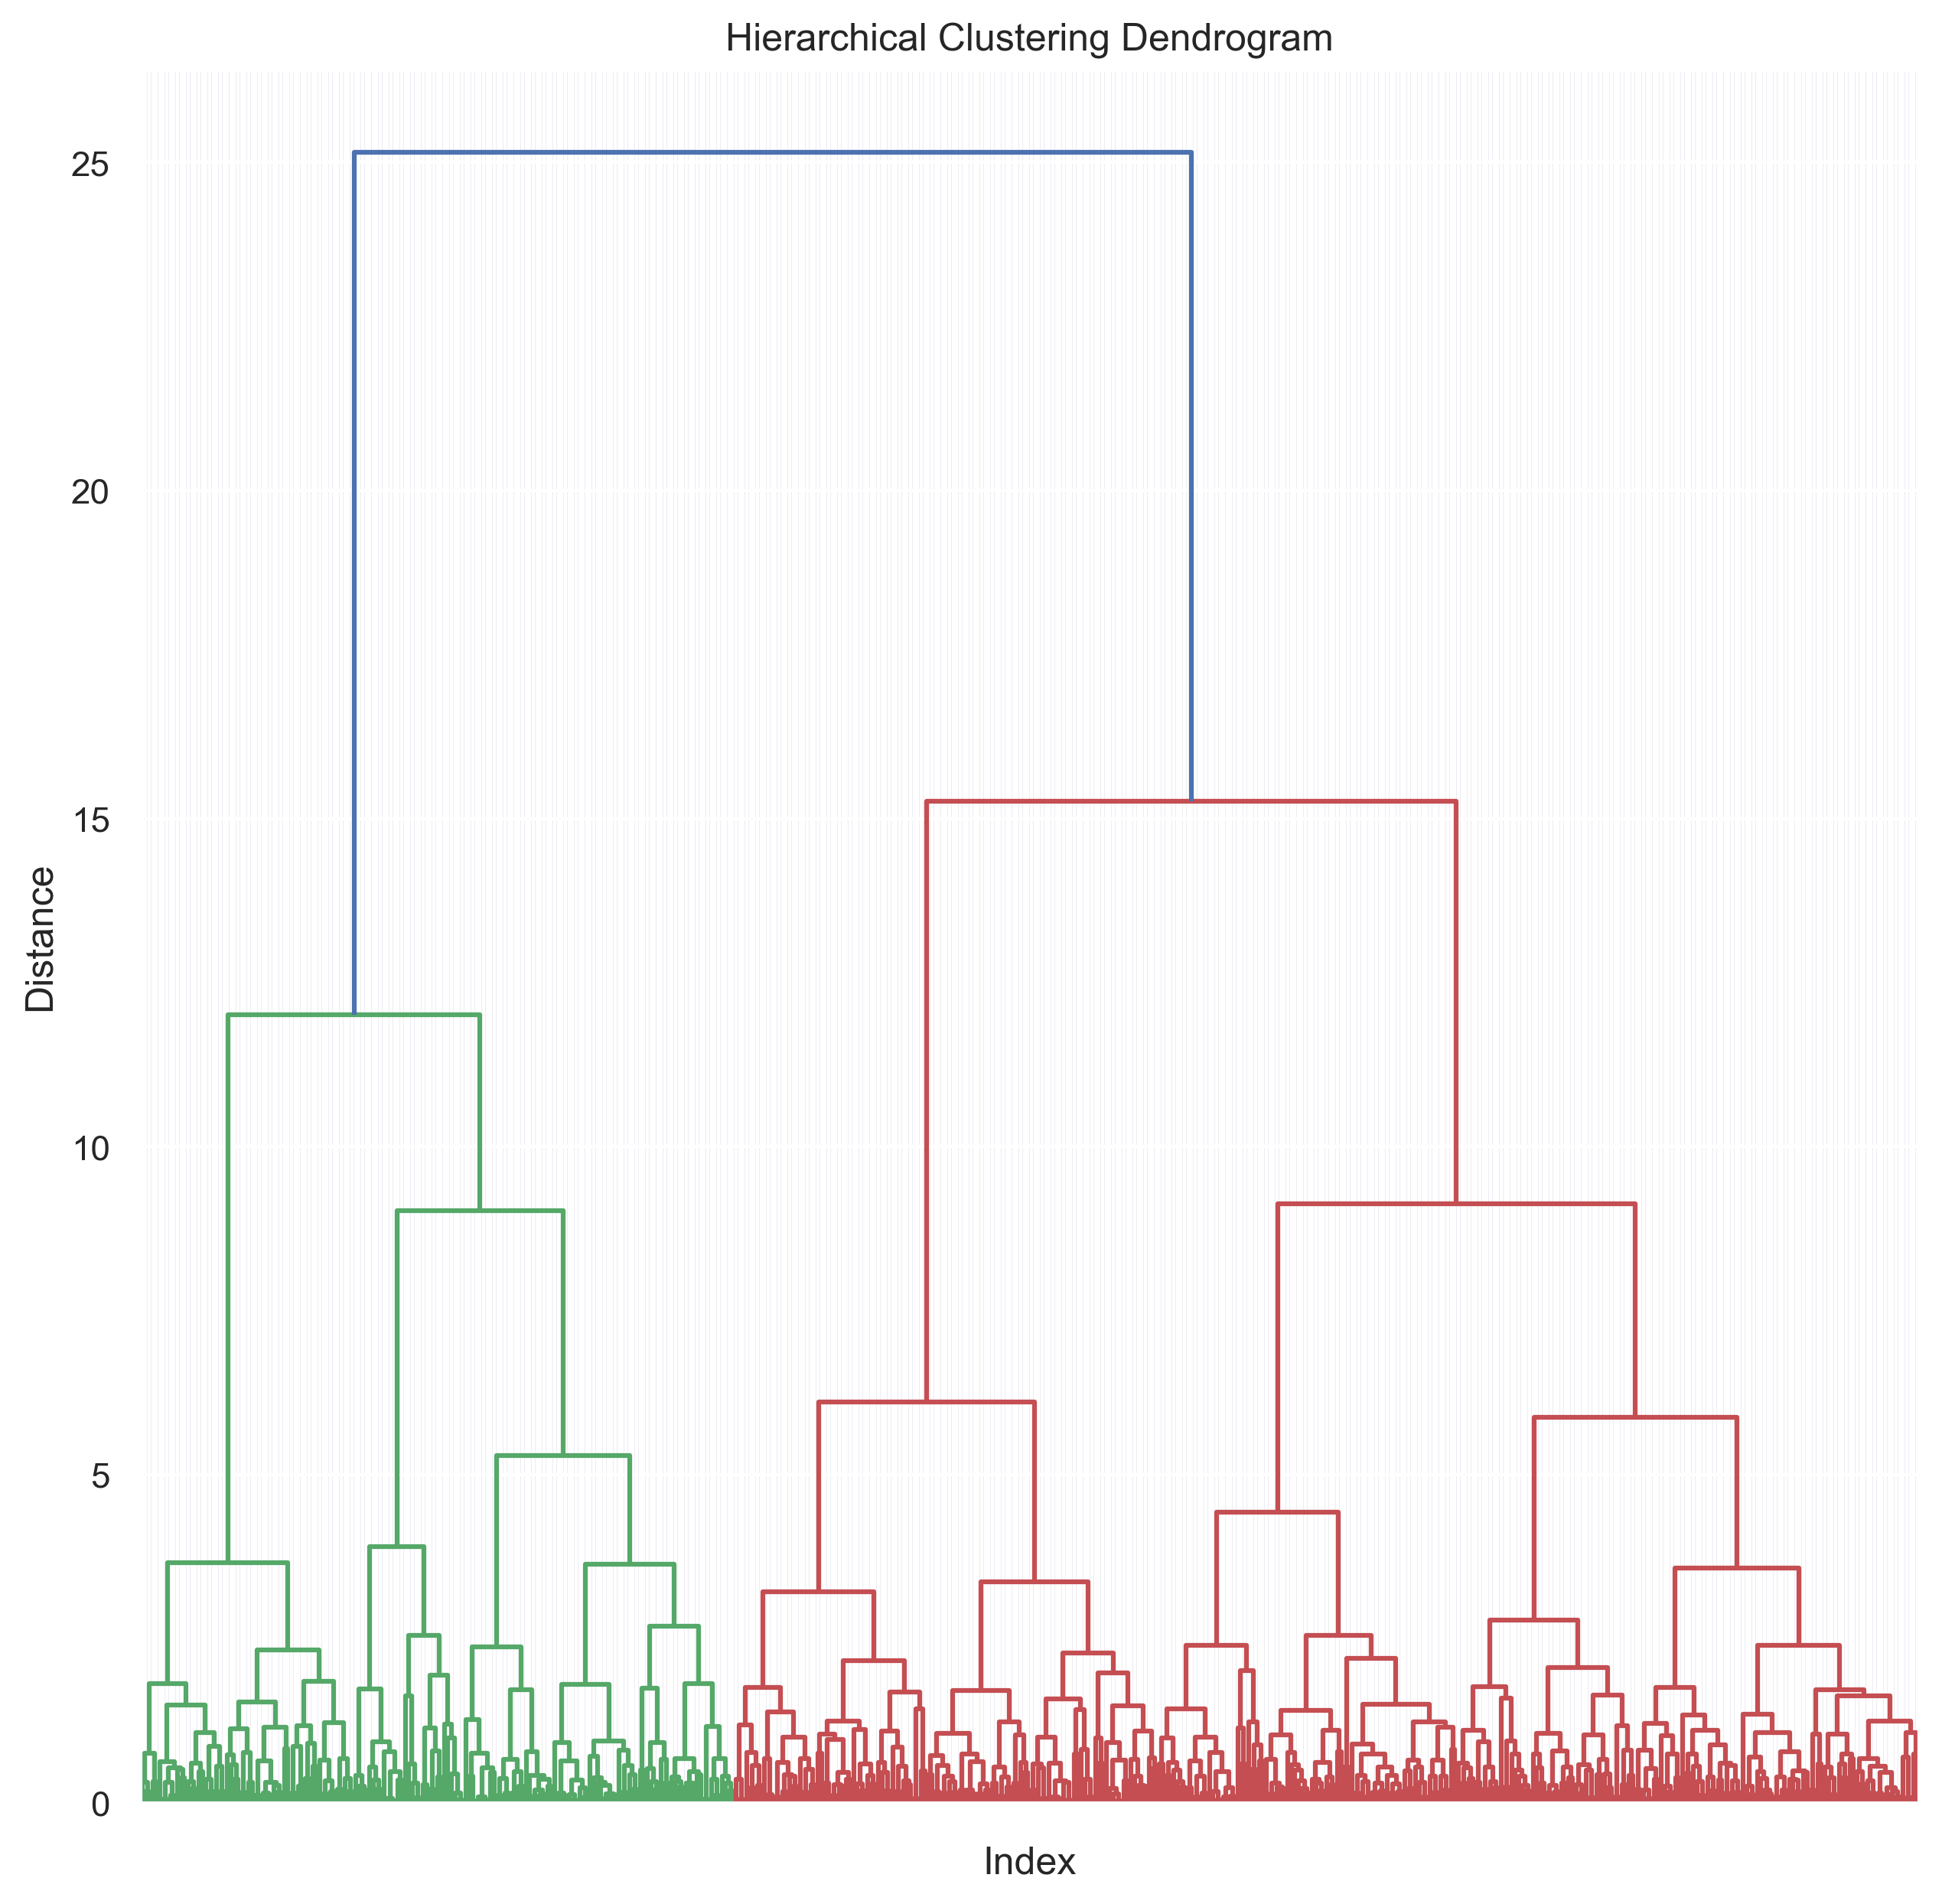

In [24]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

fig = plt.figure(figsize=(10,10),dpi=300)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
row_dendr = dendrogram(st.row_clusters)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.show()

Create the cluster labels. These will be in the same order as the original order the data was loaded. Add them to the geodataframe to plot the information.

In [25]:
cluster_labels = fcluster(st.row_clusters, 32, criterion='maxclust')

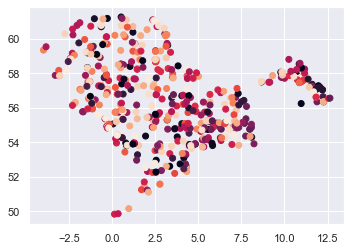

In [26]:
#gdf = gpd.GeoDataFrame(st.df,geometry=st.df[['ShootLong','ShootLat']].apply(lambda x: Point(x),axis=1),crs={'init': 'epsg:32631'})
gdf['clusters'] = cluster_labels
gdf.plot(column='clusters');

A 3d plot may also be helpful for understanding the data and clusters. For the z-axis, the number of days from the minimum date in the dataset is used as the observations z value.

In [27]:
mindt = gdf['DateTime'].min()
gdf['fromstart'] = gdf['DateTime'].apply(lambda x: (x-mindt).days)

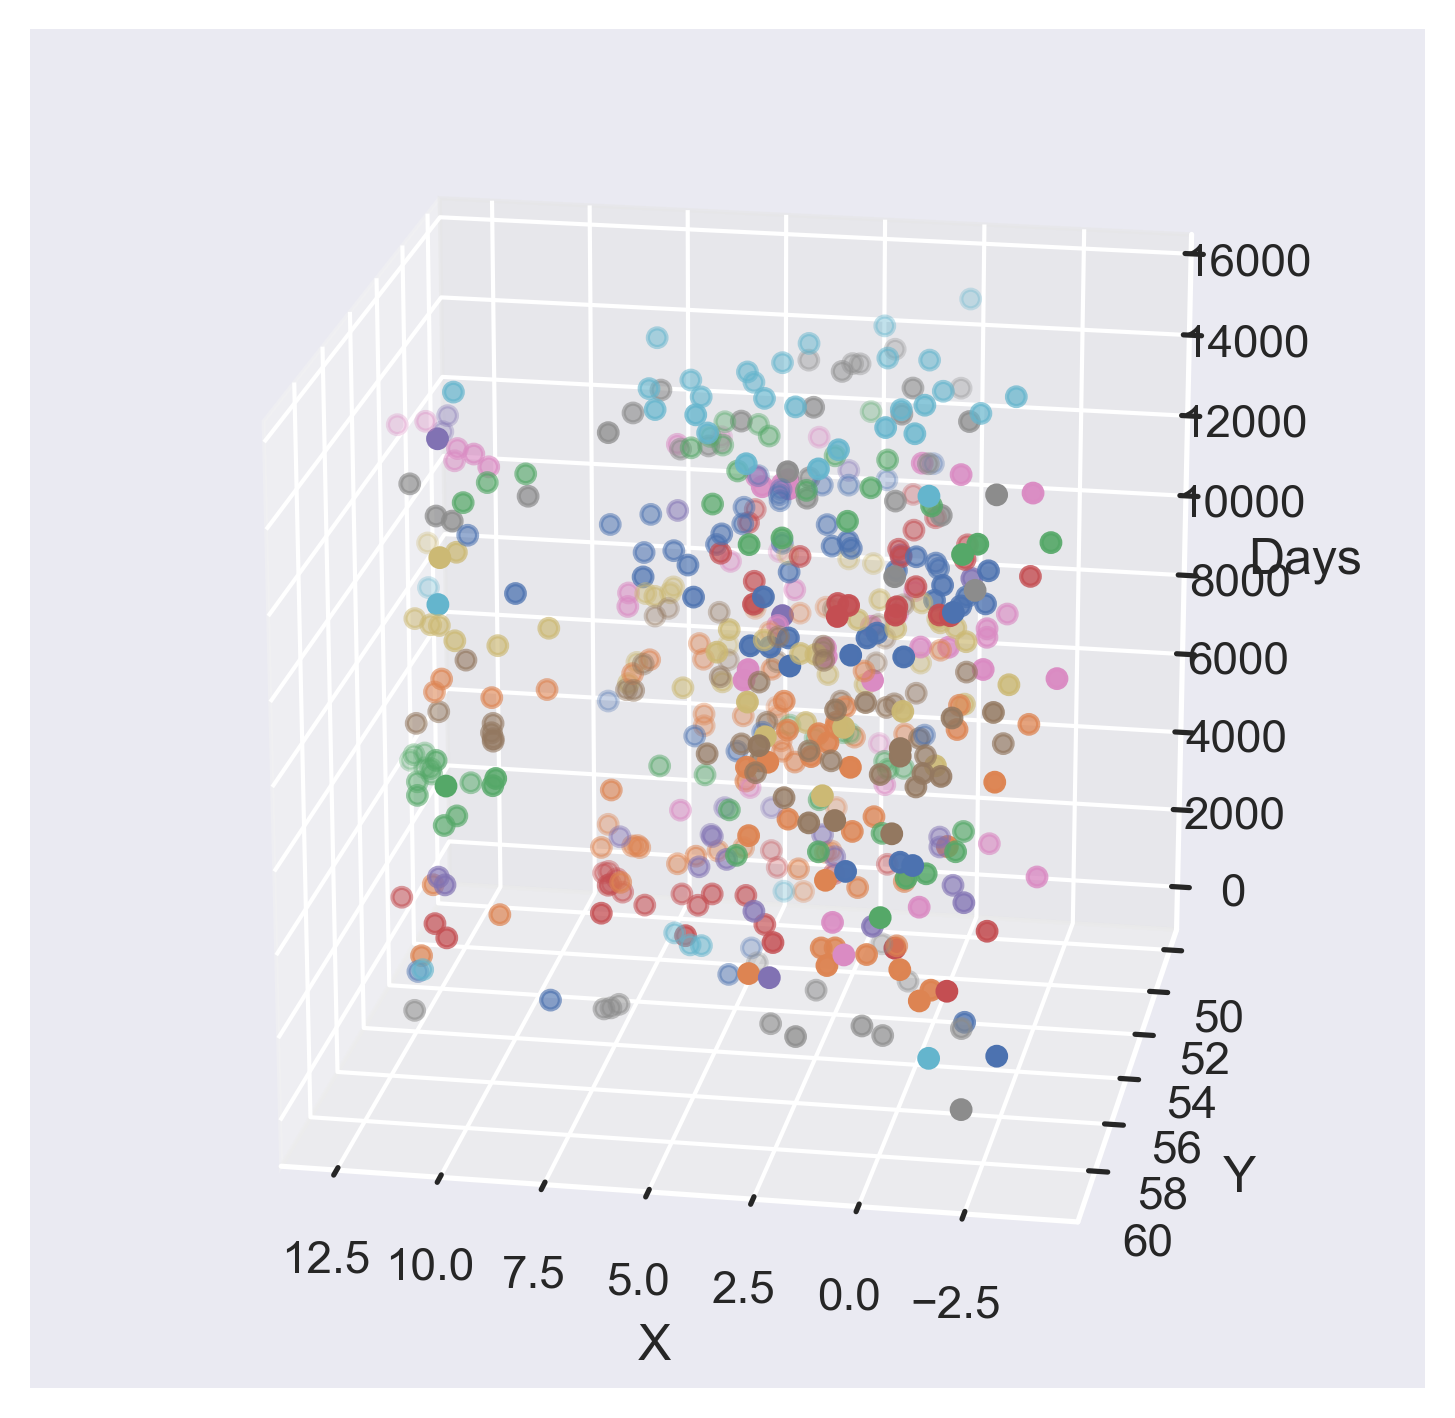

In [30]:
fig1 = plt.figure(figsize=(6,6),dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')
#ax1.set_aspect('equal')
ax1.view_init(20, 100)

for c in gdf['clusters'].unique():
    vs = gdf[gdf['clusters']==c][['ShootLong','ShootLat','fromstart']].values
    ax1.scatter(vs[:,0],vs[:,1],vs[:,2])

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Days');

# Understanding the clusters

This will create three plots on one page: the location is plotted on an open street map background, the time is plotted as a scatter plot by index, and the attributes are plotted as a boxplot (one for each attribute).

In [31]:

import contextily as ctx

#If using contextily, the projection needs to be web mercator.

gdf = gdf.to_crs(epsg=3857)


In [32]:
for c in gdf['clusters'].unique():
    fig = plt.figure(figsize=(8,8),constrained_layout=True)
    gs = fig.add_gridspec(3, 3)
    ax_map = fig.add_subplot(gs[0:2, 0:])
    ax_map.set_aspect('equal')
    ax_map.set_title("Cluster {0} Coordinates".format(c))
    ax_timerange = fig.add_subplot(gs[2, 0])
    ax_variables = fig.add_subplot(gs[2, 1:])
    gdf[gdf['clusters']==c].plot(ax=ax_map)
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    ax_map.set_xlim([gdf['geometry'].total_bounds[0],gdf['geometry'].total_bounds[2]])
    ax_map.set_ylim([gdf['geometry'].total_bounds[1],gdf['geometry'].total_bounds[3]])
    ctx.add_basemap(ax_map)
    ax_timerange.scatter(gdf[gdf['clusters']==c].index,gdf[gdf['clusters']==c][params['timedistance']['fieldnames']['datetime']])
    gdf[gdf['clusters']==c][params['attributes']['fieldnames']].boxplot(ax=ax_variables)
    plt.savefig("cluster_{0}.png".format(c),dpi=300)
    plt.close()

# Compare Samples

Take a random sample of 2000 rows from the full dataset.

In [33]:
#st.load_dataset_csv('Clupea_harengus_attributes.csv',params,32631,sample=2000)
st.load_dataset_csv('/Users/markrademaker/Projects/Spatio_temporal_clustering/Data/Clupea_harengus_attributes.csv',params,4326,sample=2000)

Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....


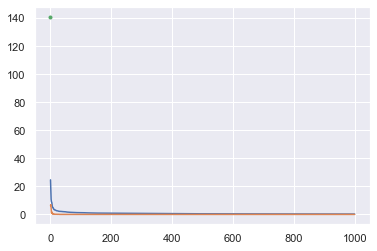

Try 141 clusters...


In [34]:
st.calculate_distance_matrix()

st.calculate_clusters()
a = st.elbow_alt()

Try 2 clusters...
Try 32 clusters...


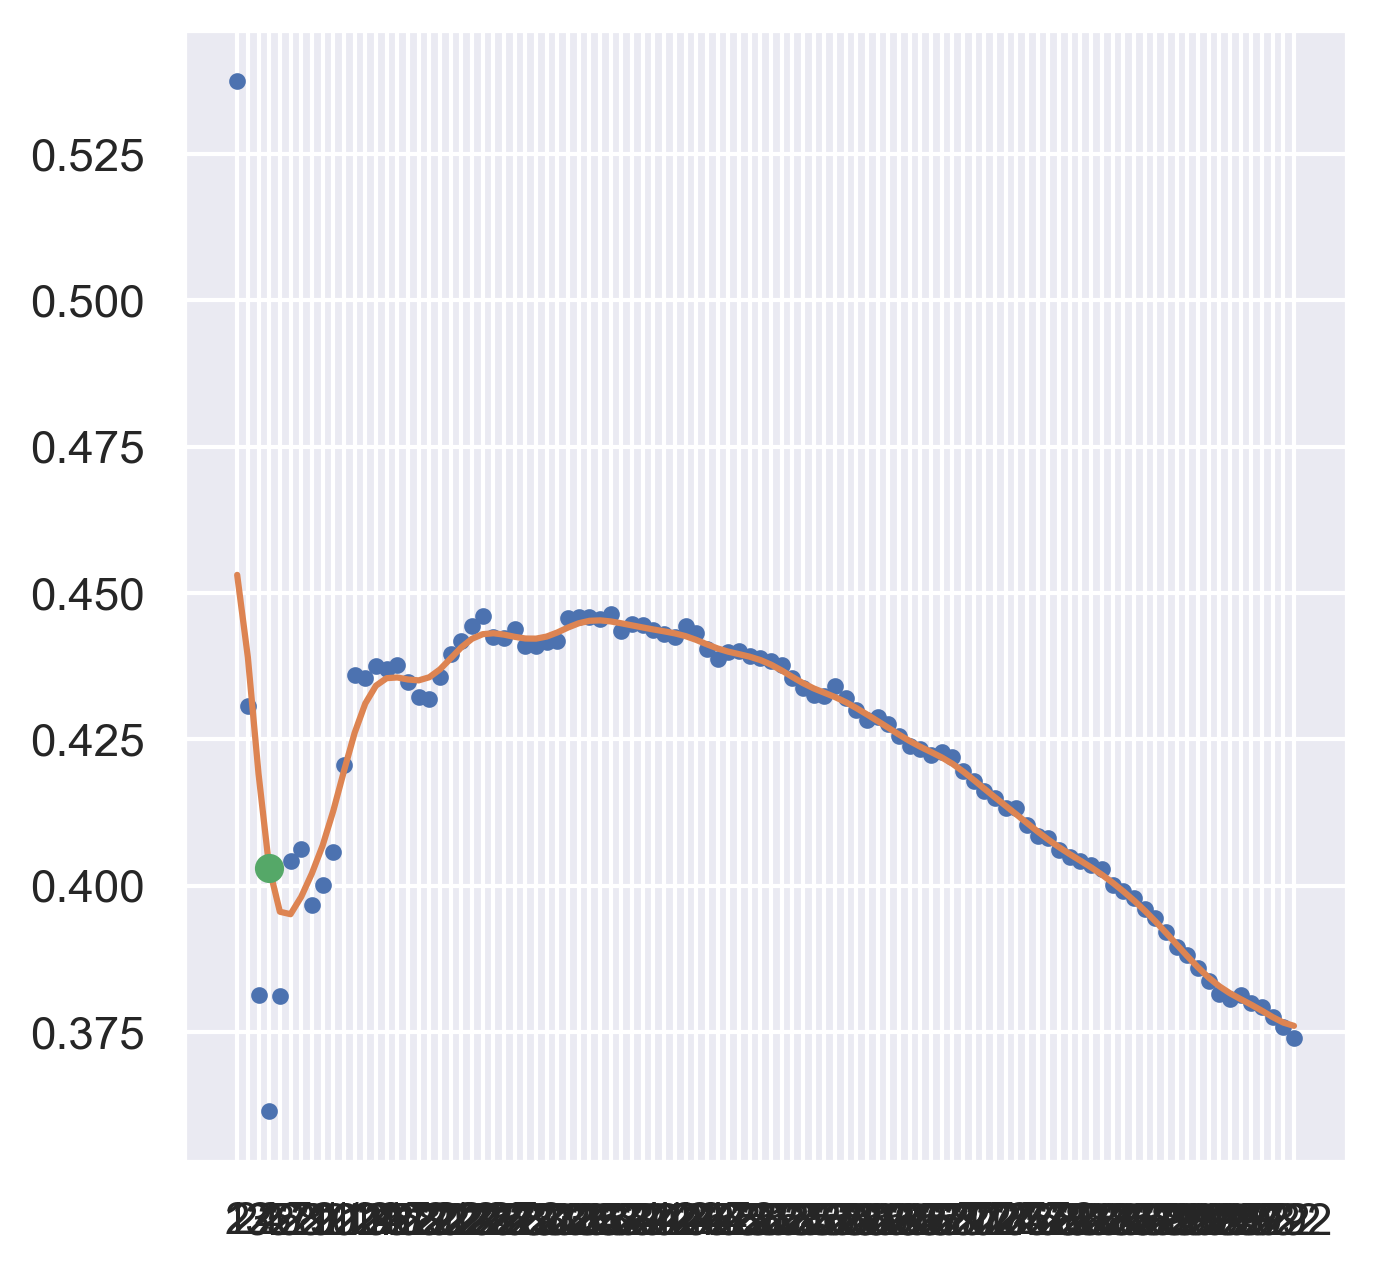

In [35]:
a = st.silhoutte_scores_n_clusters()

In [36]:
cluster_labels_32 = fcluster(st.row_clusters, 32, criterion='maxclust')
cluster_labels_200 = fcluster(st.row_clusters, 200, criterion='maxclust')
st.df['clusters_32'] = cluster_labels_32
st.df['clusters_200'] = cluster_labels_200
st.df.to_csv("sample_2000_with_clusters.csv")
name = "sample_2000_with_clusters.csv"

In [37]:
from sklearn import metrics

rand_ind_32 = []
rand_ind_200 = []
homogeneity_32 = []
completeness_32 = []
homogeneity_200 = []
completeness_200 = []
for i in range(0,100):
    st = STHC()
    
    st.load_dataset_csv(name,params,sample=600)
    true_labels_32 = st.df['clusters_32'].values
    true_labels_200 = st.df['clusters_200'].values
    
    st.calculate_distance_matrix()

    st.calculate_clusters()

    cluster_labels_32 = fcluster(st.row_clusters, 32, criterion='maxclust')
    cluster_labels_200 = fcluster(st.row_clusters, 200, criterion='maxclust')
    
    rand_ind_32.append(metrics.adjusted_rand_score(true_labels_32,cluster_labels_32))
    rand_ind_200.append(metrics.adjusted_rand_score(true_labels_200,cluster_labels_200))
    homogeneity_32.append(metrics.homogeneity_score(true_labels_32,cluster_labels_32))
    homogeneity_200.append(metrics.homogeneity_score(true_labels_200,cluster_labels_200))
    completeness_32.append(metrics.completeness_score(true_labels_32,cluster_labels_32))
    completeness_200.append(metrics.completeness_score(true_labels_200,cluster_labels_200))
    print(i)

Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
0
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
1
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
2
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
3
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
4
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
5
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
6
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attrib

63
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
64
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
65
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
66
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
67
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
68
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
69
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....
70
Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Prepar

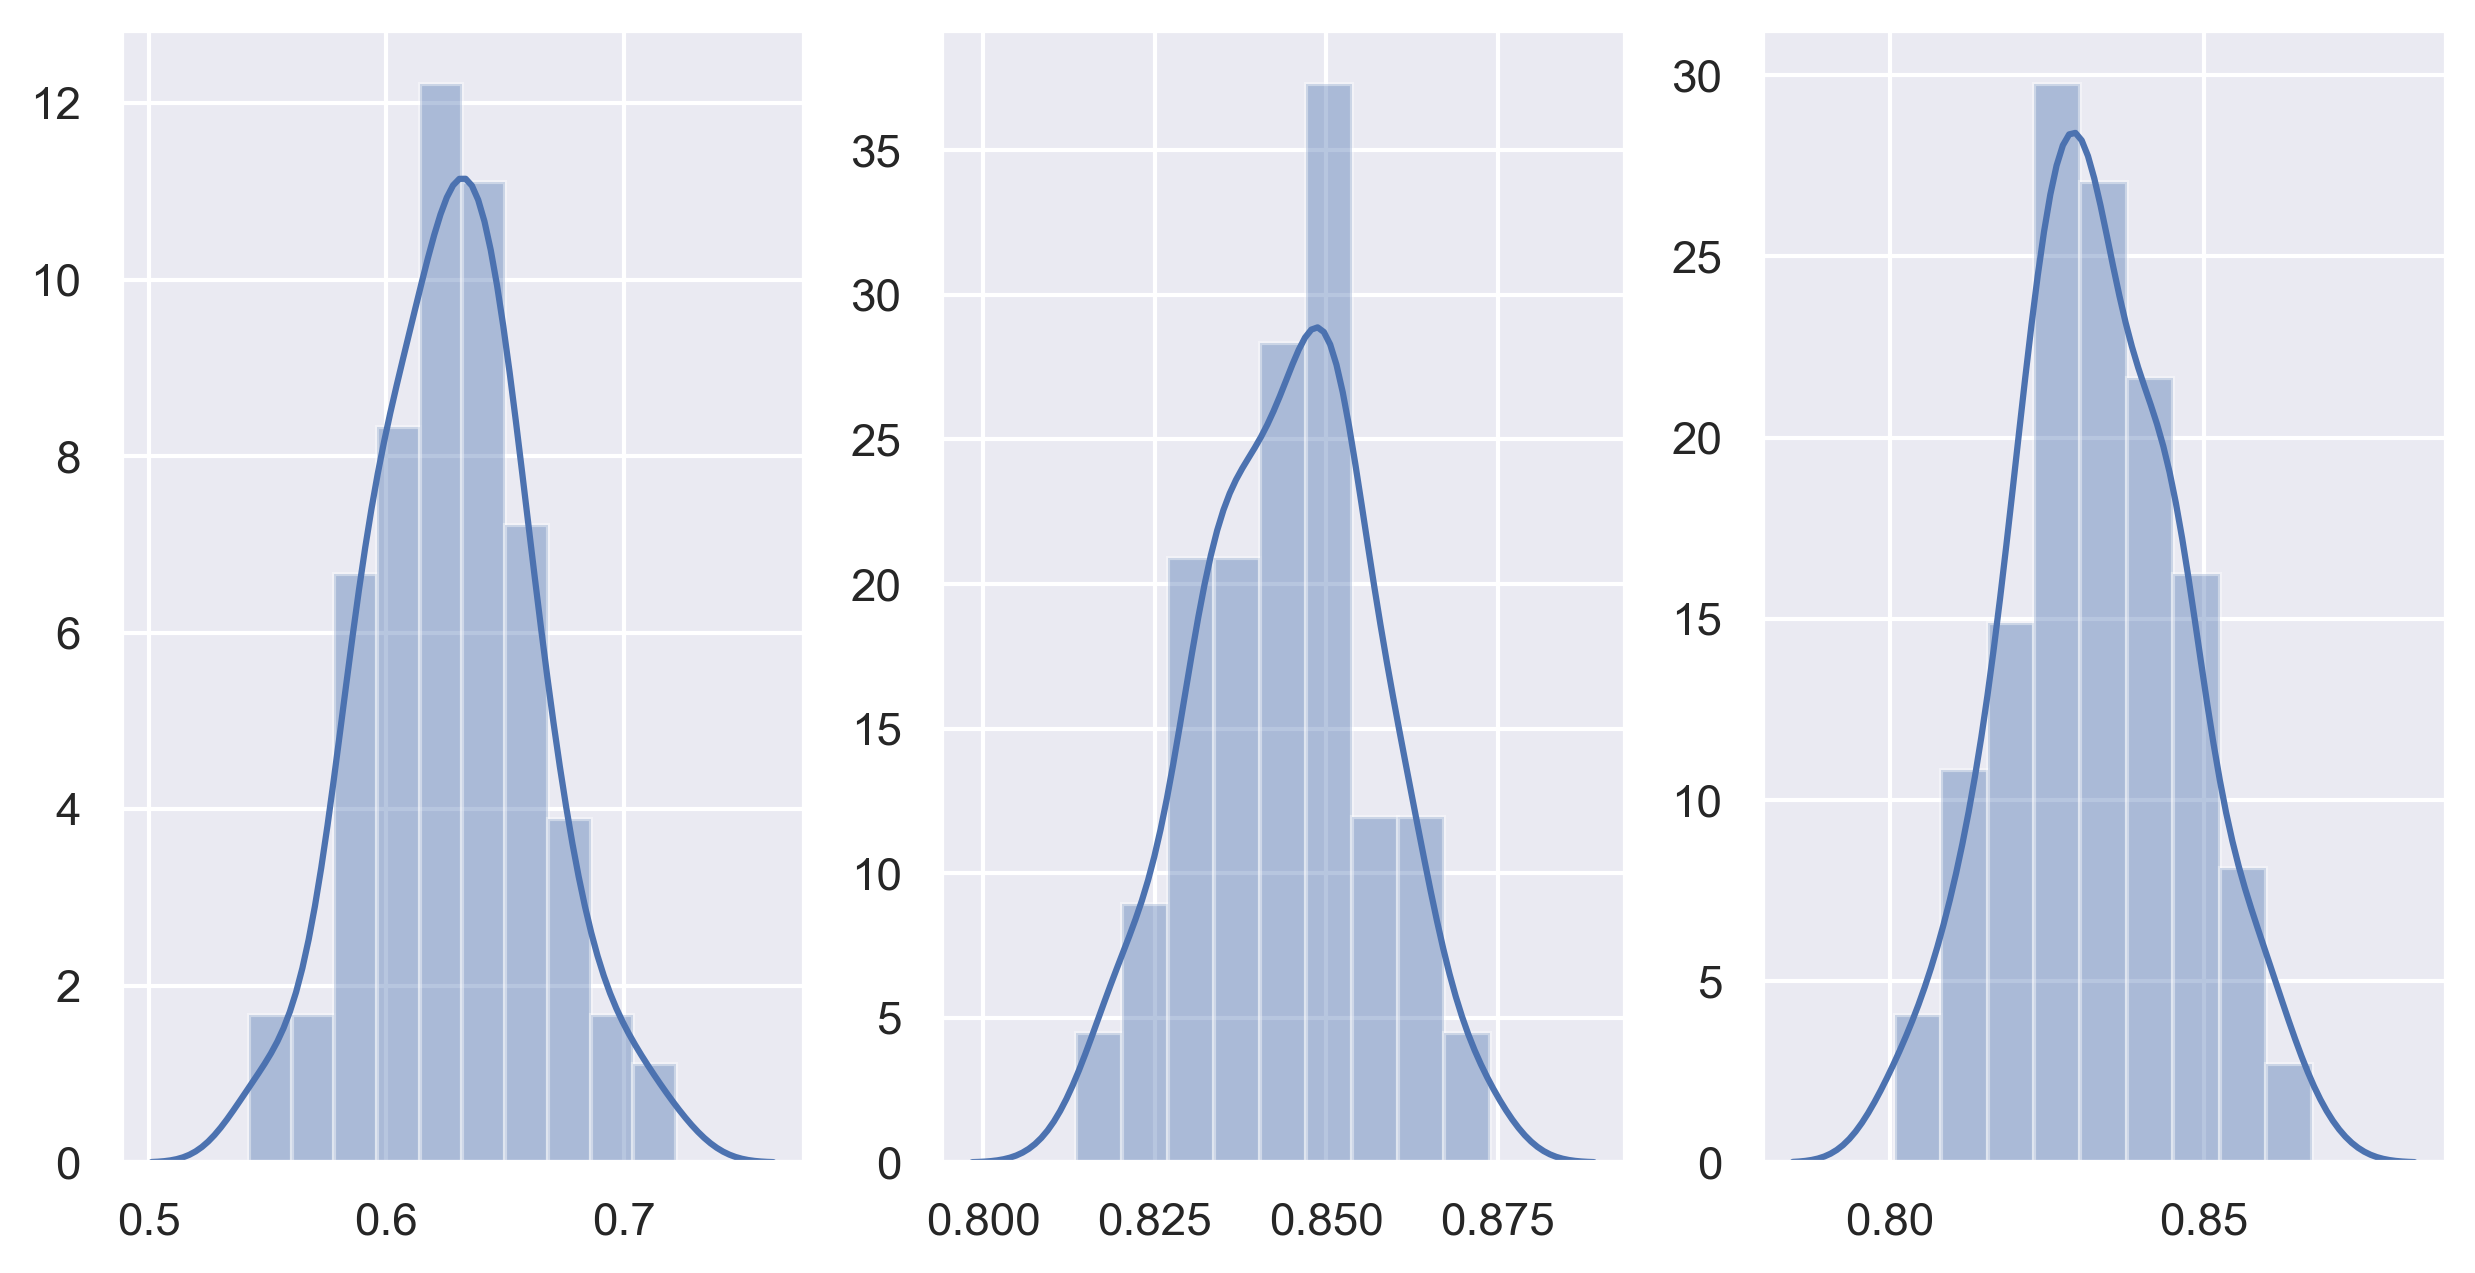

In [38]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_subplot(131)
sns.distplot(rand_ind_32,ax=ax);
ax = fig.add_subplot(132)
sns.distplot(homogeneity_32,ax=ax);
ax = fig.add_subplot(133)
sns.distplot(completeness_32,ax=ax);

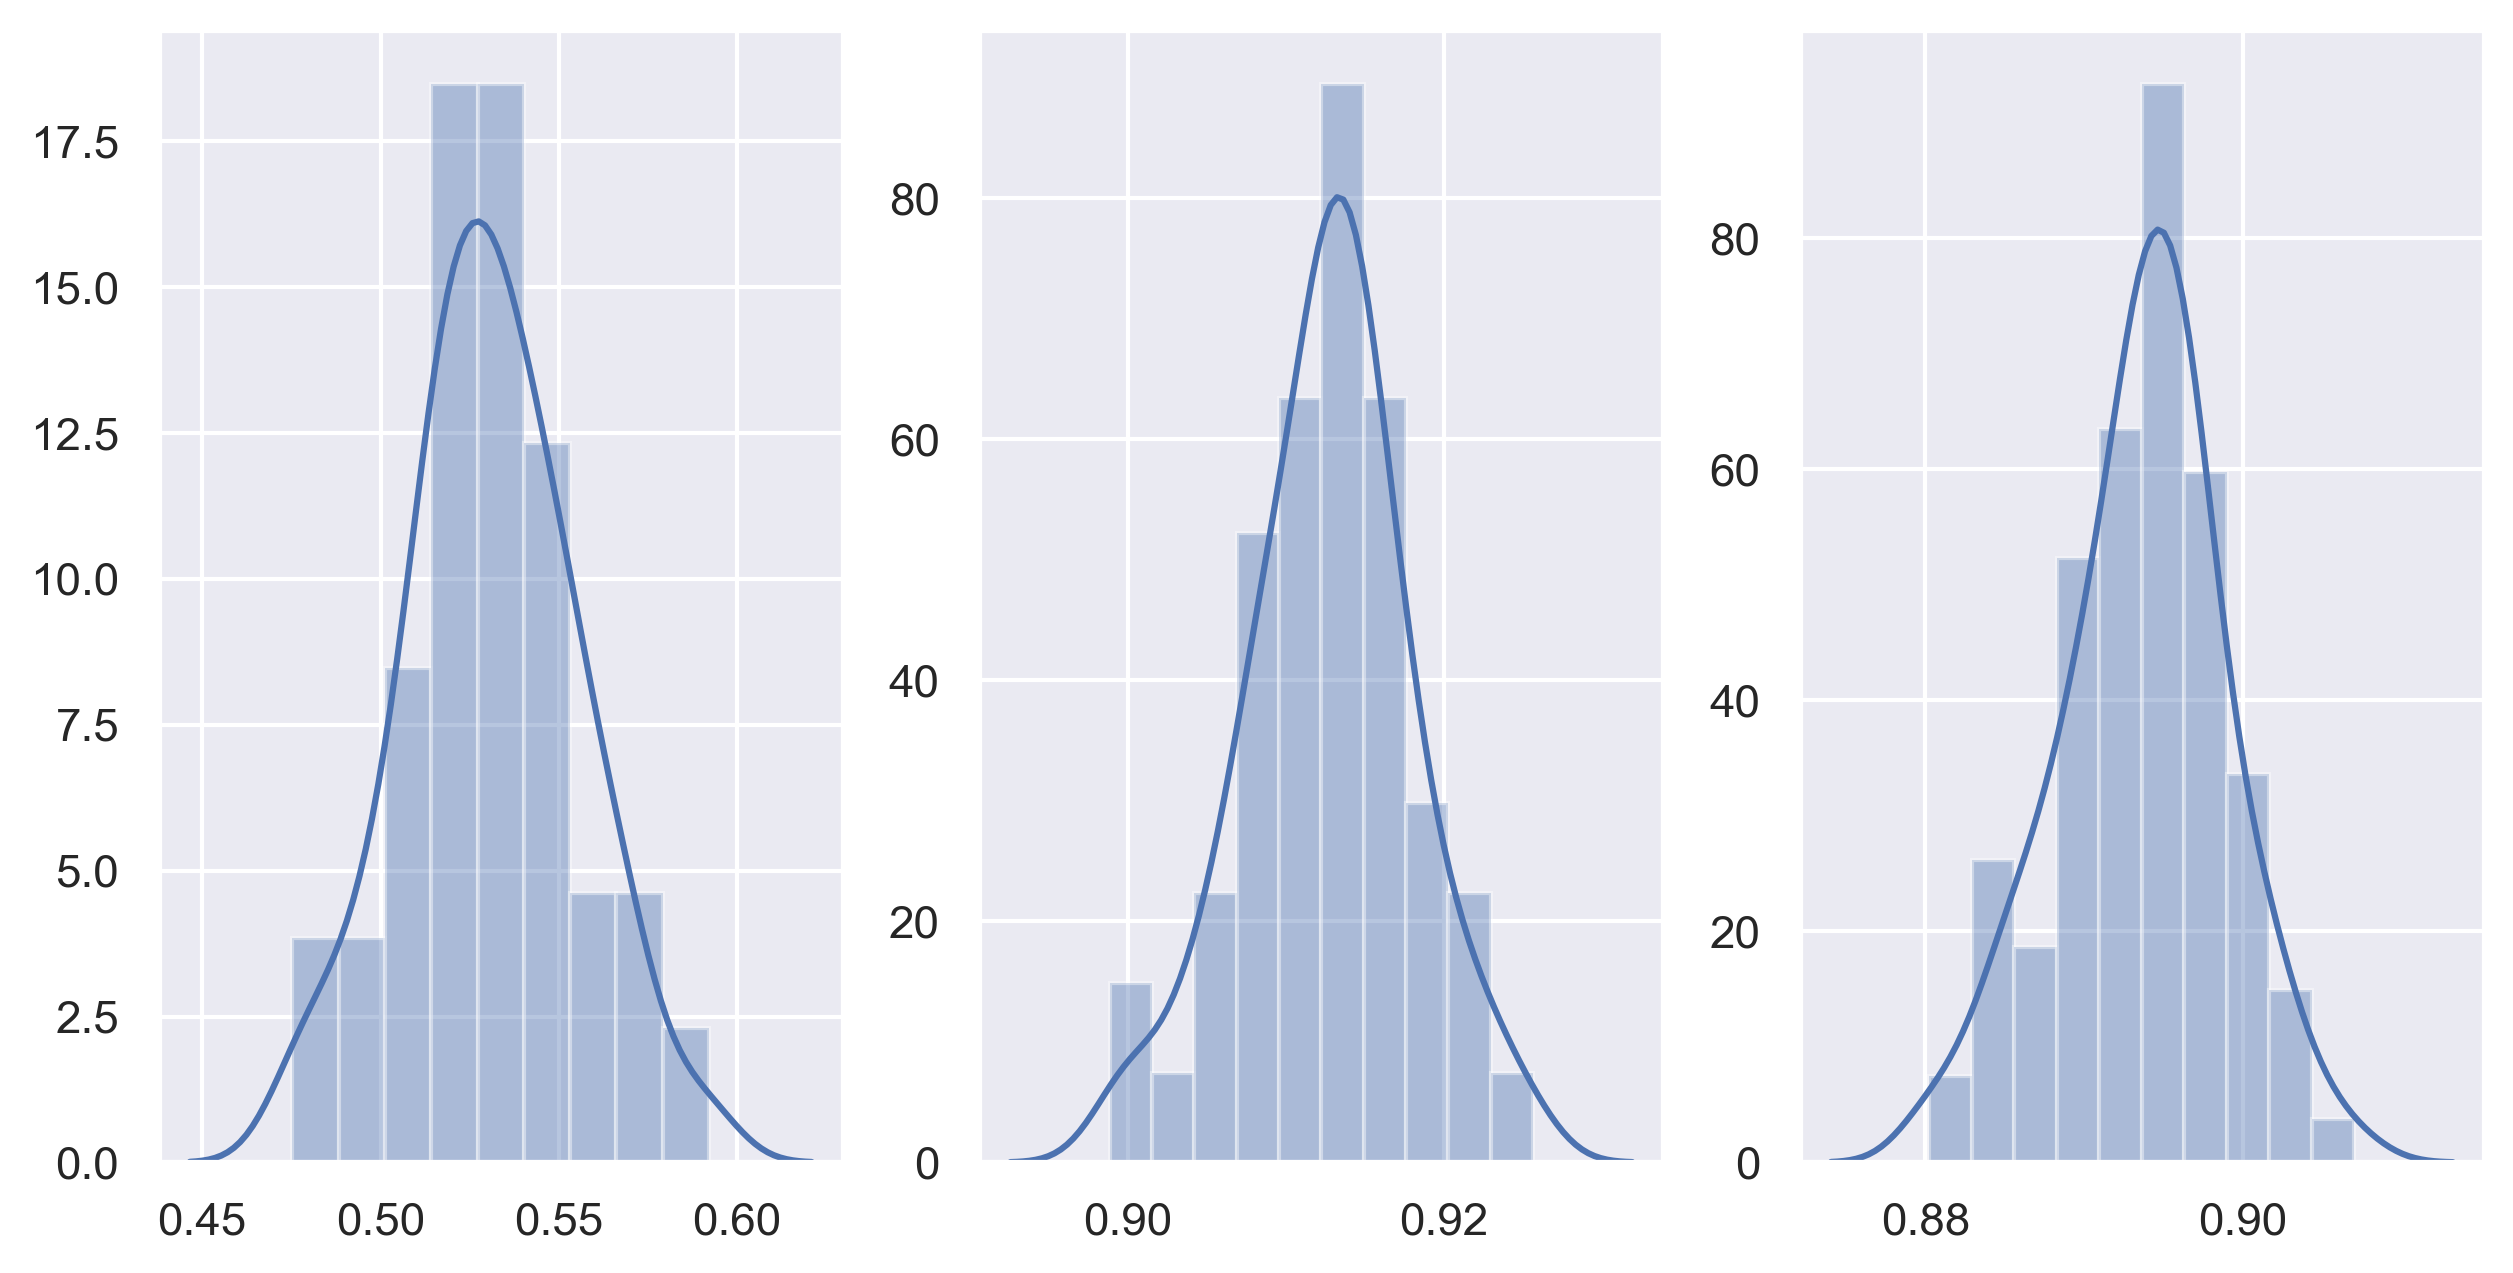

In [39]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_subplot(131)
sns.distplot(rand_ind_200,ax=ax);
ax = fig.add_subplot(132)
sns.distplot(homogeneity_200,ax=ax);
ax = fig.add_subplot(133)
sns.distplot(completeness_200,ax=ax);